#### 1. Code used to extract the Data into the folder

In [ ]:
from pyunpack import Archive
Archive('train.7z').extractall('/home/joseph180598')

#### 2. Importing all the library dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
import codecs
import csv
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import random as r
from sklearn.feature_extraction.text import CountVectorizer
import scipy
import random
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


C:\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!conda create -n py37 python=3.7.8 anaconda
#https://stackoverflow.com/questions/49428381/how-to-change-jupyter-kernel-from-python-2-to-python-3

Solving environment: ...working... failed



CondaValueError: Malformed version string '~': invalid character(s).



In [4]:
!source active py37


'source' is not recognized as an internal or external command,
operable program or batch file.


#### 3. Separating ASM & Byte Files and Placing them in different folders

In [ ]:
#separating byte files and asm files 

source = 'train'
destination = 'byteFiles'

# we will check if the folder 'byteFiles' exists if it not there we will create a folder with the same name
if not os.path.isdir(destination):
    os.makedirs(destination)

# if we have folder called 'train' (train folder contains both .asm files and .bytes files) we will rename it 'asmFiles'
# for every file that we have in our 'asmFiles' directory we check if it is ending with .bytes, if yes we will move it to
# 'byteFiles' folder
#source='asmFiles'
# so by the end of this snippet we will separate all the .byte files and .asm files
if os.path.isdir(source):
    os.rename(source,'asmFiles')
    source='asmFiles'
    data_files = os.listdir(source)
    for file in data_files:
        if (file.endswith(".bytes")):
            shutil.move(source+'/'+file,destination)

#### As an additional step, I had converted the ASM files to text files before processing, so that can be treated as a txt file, and features can be extracted easily without errors.

In [ ]:
#Converting the ASM Files to text files, so that I can read them using the normal open function
#Step
files=os.listdir('asmFiles')
for f in tqdm(files):
    name=f.split('.')[0]
    if f.endswith('.asm'):
        with codecs.open('asmFiles/'+f,encoding='cp1252',errors ='replace') as fp:
            with codecs.open('asmFiles/'+name+'.txt','w',encoding='cp1252',errors ='replace') as f2:
                for line in fp:
                    f2.write(line)
            f2.close()
        os.remove('asmFiles/'+f)

#### I assumed that I was handling this use case for the first time. So I had split the dataset into 2 sets, training & testing. So that they are separated from the training to the test phase.

In [ ]:
#splitting the data into train & test
#Step 2

files_byte=os.listdir('byteFiles')
total_file=len(files_byte)

files_asm=os.listdir('asmFiles')

data=pd.read_csv('trainLabels.csv')
data.head()
#The y_csv file is file_name, Class

train=random.sample(range(total_file),int(total_file*0.8))
test=list(set(range(total_file))-set(train))

In [ ]:
#Step 3: Actually moving the files
import shutil
source1='asmFiles'
source2='byteFiles'
#ASM File
train_dest_asm='asmFiles_train'
test_dest_asm='asmFiles_test'
#Byte File
train_dest_byte='byteFiles_train'
test_dest_byte='byteFiles_test'


if not os.path.isdir(test_dest_asm):
    os.makedirs(test_dest_asm)
    
if not os.path.isdir(test_dest_byte):
    os.makedirs(test_dest_byte)

#Moving the test data from the main file
for index in test:
    shutil.move(source2 +'/'+files_byte[index],test_dest_byte)
    shutil.move(source1 +'/'+files_asm[index],test_dest_asm)
    
os.rename(source1,train_dest_asm)
os.rename(source2,train_dest_byte)


In [ ]:
#Verifying if the files were moved correctly
len(os.listdir('byteFiles_test'))==len(os.listdir('asmFiles_test'))

### 4. Distribution of malware classes in whole data set

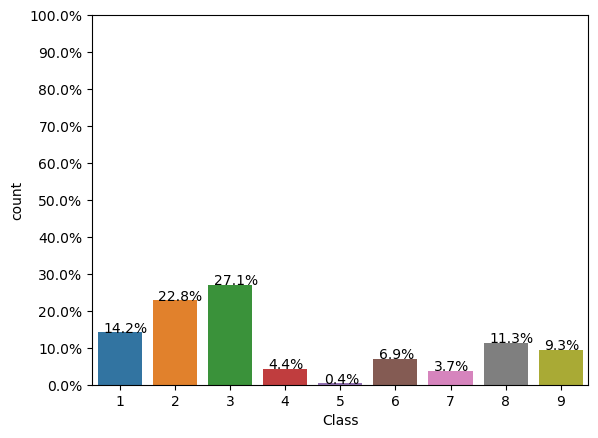

In [2]:
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

### Distribution of Class in Training and Testing

In [3]:
#Training
train_folder=os.listdir('byteFiles_train')
test_folder=os.listdir('byteFiles_test')

train=[]
test=[]
for files in train_folder:
    train.append(files.split('.')[0])

for files in test_folder:
    test.append(files.split('.')[0])

In [4]:
class_detail=pd.read_csv('trainLabels.csv', delimiter=',')
class_detail.shape

(10868, 2)

In [5]:
train_class=[]
for values in tqdm(train):
    train_class.append(int(class_detail[class_detail['Id']==values]['Class']))
    
test_class=[]
for values in tqdm(test):
    test_class.append(int(class_detail[class_detail['Id']==values]['Class']))

100%|████████████████████████████████████████████████████████████████████| 2174/2174 [00:01<00:00, 1222.59it/s]


In [7]:
train_class=pd.DataFrame(list(zip(train,train_class)),columns =['Id','Class'])
test_class=pd.DataFrame(list(zip(test,test_class)),columns =['Id','Class'])

### Distribution of Class in Training Data

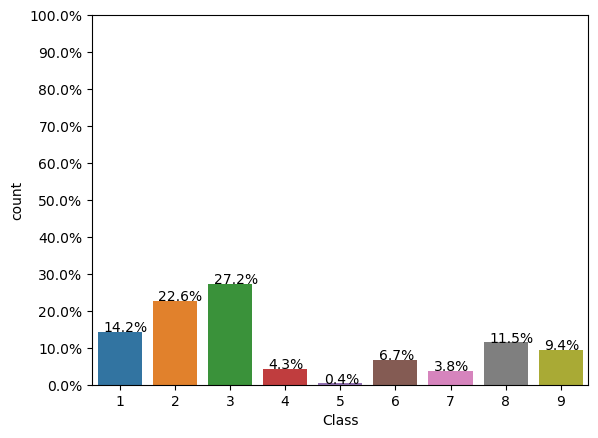

In [9]:

total = len(train_class)*1.
ax=sns.countplot(x="Class", data=train_class)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

#### Distribution of Class in Training Data

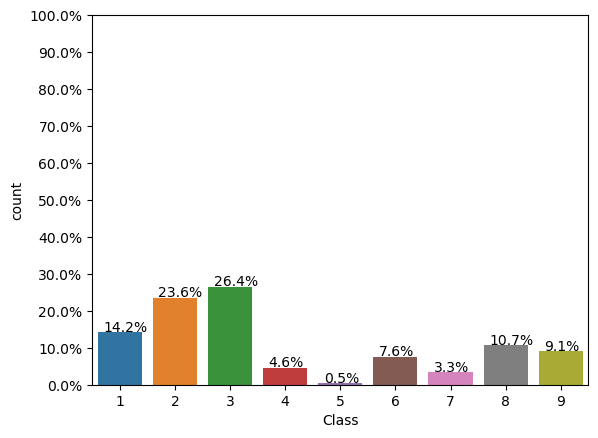

In [31]:

total = len(test_class)*1.
ax=sns.countplot(x="Class", data=test_class)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

### 5. Feature Extraction
#### 5.1 File Size

In [38]:
#file sizes of train byte files

files=os.listdir('byteFiles_train')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('byteFiles_train/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
train_data_size_byte=pd.DataFrame({'Id':fnames,'size':sizebytes,'Class':class_bytes})
print (train_data_size_byte.head())

                     Id      size  Class
0  clDmndwYzEaRtyrQusUJ  2.166504      6
1  JEbogFC9kPnGSdi2KDaZ  8.099609      3
2  0DqUX5rkg3IbMY6BLGCE  0.651367      1
3  9vP6c42rE30zVNlT8AJO  8.113770      3
4  6iSL1WkDHVIUqJzGmnhN  5.210938      7


In [37]:
#file sizes of test byte files

files=os.listdir('byteFiles_test')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('byteFiles_test/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
test_data_size_byte=pd.DataFrame({'Id':fnames,'size':sizebytes,'Class':class_bytes})
print (test_data_size_byte.head())

                     Id      size  Class
0  G9tcxvXL8sZAjU72zYOg  0.594727      4
1  iEhMwSYF4f7O6clnzgv0  0.523926      1
2  351BNOEjS9pHWAqhJQdD  1.118652      8
3  4eC9LmdHc6pRoP8BtTGv  8.099609      3
4  HQCNdPn3ytMDrB96b8kX  8.099609      3


### 5.2 Byte File Features
#### 5.2.1 Bag Of Words on the hexadecimal code

In [ ]:
#First extracting the vocab dictionary which is necessary for the BOW
#Running the code to get a dictionary of byte values in byte file
#extracting the byte from the values
import os
from tqdm import tqdm
import csv
files=os.listdir('byteFiles_train')
byte_vocab=set()
for file in tqdm(files):
    if file.endswith('.bytes'):
        sheet=open('byteFiles_train/'+file)
        sheet.seek(0)
        data=sheet.readlines()
        for i in data:
            byte_vocab.update(i[9:-1].split(' '))
        #print(len(byte_vocab))
        
byte_vocab=list(byte_vocab)
fp=open('bytes_hexa_vocab.txt','w')
for j in byte_vocab:
    fp.write(j+',')
#Converting the set into a list and storing the data in a txt file

In [10]:
import pandas as pd
byte_vocab=list(pd.read_csv('bytes_hexa_vocab.txt',delimiter=',',header=None, dtype=str).to_numpy()[0])
#calling that vocab and converting into a list for creating BOW

In [ ]:
#Running the code to get a dictionary of addresses in byte file
#extracting the address from the values
import os
from tqdm import tqdm
import csv
files=os.listdir('byteFiles_train')
file_address=set()
for file in tqdm(files):
    if file.endswith('.bytes'):
        sheet=open('byteFiles_train/'+file)
        sheet.seek(0)
        data=sheet.readlines()
        for i in data:
            file_address.add(i[:8])
        #print(len(file_address))
        
fp=open('byte_address_vocab.txt','w')
file_address=list(file_address)
for j in file_address:
    fp.write(j+',')
#Saving the vocabulary as dict

#### Tried using the address, but it has a vocabulary of 8536801 values, hence may not be really a good feature

#### Creating BOW with the bytes file

In [ ]:
#https://mkyong.com/python/python-difference-between-r-w-and-a-in-open/#difference-between-r-r-w-w-a-and-a
#CHange the values to a if it stops in the middle
#https://github.com/saicharanarishanapally/microsoft-malware-detection/blob/master/MicrosoftMalwareDetection.ipynb

#https://github.com/saicharanarishanapally/microsoft-malware-detection/blob/master/MicrosoftMalwareDetection.ipynb
vector = CountVectorizer(lowercase=False,ngram_range=(1,1), vocabulary=byte_vocab)
with open('train_bytes_BOW.csv','w') as fp:
    write=csv.writer(fp)
    for i, file in tqdm(enumerate(os.listdir('byteFiles_train'))):
        if file.endswith('.bytes'):
            name=file.split('.')[0]
            f = open('byteFiles_train/' + file)
            vec=scipy.sparse.csr_matrix(vector.transform([f.read().replace('\n', ' ').upper()]))
            vec=vec.toarray()[0]
            vec=list(vec)
            vec.insert(0,name)
            write.writerow(vec)
            f.close()
    fp.close()

In [10]:
#https://mkyong.com/python/python-difference-between-r-w-and-a-in-open/#difference-between-r-r-w-w-a-and-a
#CHange the values to a if it stops in the middle
#https://github.com/saicharanarishanapally/microsoft-malware-detection/blob/master/MicrosoftMalwareDetection.ipynb

#https://github.com/saicharanarishanapally/microsoft-malware-detection/blob/master/MicrosoftMalwareDetection.ipynb
vector = CountVectorizer(lowercase=False,ngram_range=(1,1), vocabulary=byte_vocab)
with open('test_bytes_BOW.csv','w') as fp:
    write=csv.writer(fp)
    for i, file in tqdm(enumerate(os.listdir('byteFiles_test'))):
        if file.endswith('.bytes'):
            name=file.split('.')[0]
            f = open('byteFiles_test/' + file)
            vec=scipy.sparse.csr_matrix(vector.transform([f.read().replace('\n', ' ').upper()]))
            vec=vec.toarray()[0]
            vec=list(vec)
            vec.insert(0,name)
            write.writerow(vec)
            f.close()
    fp.close()

2174it [20:38,  1.76it/s]


#### 2-gram BOW

In [ ]:
dictionary=byte_vocab

bigram_vocab=set()
for w1 in tqdm(dictionary):
    for w2 in dictionary:
        b=str(w1)+' '+str(w2)
        bigram_vocab.add(b)

f=open('bigram_vocab.txt','w')
for j in list(bigram_vocab):
    f.write(str(j)+',')


In [11]:
bigram_vocab=list(pd.read_csv('bigram_vocab.txt',delimiter=',',header=None, dtype=str).to_numpy()[0])
column_names=bigram_vocab
column_names.insert(0,'Id')

In [3]:
#creating BOW of 2-gram data
vector = CountVectorizer(lowercase=False,ngram_range=(2,2), vocabulary=bigram_vocab)
with open('train_bigram_BOW1.csv','w') as fp:
    write=csv.writer(fp)
    write.writerow(column_names)
    for i, file in tqdm(enumerate(os.listdir('byteFiles_train'))):
        if file.endswith('.bytes'):
            name=file.split('.')[0]
            f = open('byteFiles_train/' + file)
            vec=scipy.sparse.csr_matrix(vector.transform([f.read().replace('\n', ' ').upper()]))
            vec=vec.toarray()[0]
            vec=list(vec)
            vec.insert(0,name)
            write.writerow(vec)
            f.close()
    fp.close()

8690it [2:31:06,  1.04s/it]


In [4]:
#creating BOW of 2-gram data
vector = CountVectorizer(lowercase=False,ngram_range=(2,2), vocabulary=bigram_vocab)
with open('test_bigram_BOW1.csv','w') as fp:
    write=csv.writer(fp)
    write.writerow(column_names)
    for i, file in tqdm(enumerate(os.listdir('byteFiles_test'))):
        if file.endswith('.bytes'):
            name=file.split('.')[0]
            f = open('byteFiles_test/' + file)
            vec=scipy.sparse.csr_matrix(vector.transform([f.read().replace('\n', ' ').upper()]))
            vec=vec.toarray()[0]
            vec=list(vec)
            vec.insert(0,name)
            write.writerow(vec)
            f.close()
    fp.close()

2174it [46:19,  1.28s/it]


In [ ]:
from tqdm import tqdm

dictionary=byte_vocab

bigram_vocab=set()
for w1 in tqdm(dictionary):
    for w2 in dictionary:
        for w3 in dictionary:
            b=str(w1)+' '+str(w2) +str(w3)
            bigram_vocab.add(b)

f=open('trigram_vocab.txt','w')
for j in list(bigram_vocab):
    f.write(str(j)+',')
#code to get the trigram vocabulary but it has 259*258*257 values which is very huge hence not performing BOW for 3 gram

### Creating Image Files from the byte file

In [ ]:
#https://github.com/RezaPurut/convert_malware_bytes_to_img/blob/master/conv_to_img.py
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image

def saveimg(array,name):
    print(name)
    print (array.shape)
    if array.shape[1]!=16:
        assert(False)
    b=int((array.shape[0]*16)**(0.5))
    b=2**(int(log(b)/log(2))+1)
    a=int(array.shape[0]*16/b)
    print (a,b,array.shape)
    array=array[:int(a*b/16),:]

    array=np.reshape(array,(a,b))
    #print array.shape
    #array = np.uint8(array)
    #print array
    #array.resize((128,128))
     
    im = Image.fromarray(np.uint8(array))
    im.save('images/'+name[:-6]+'.jpg', "JPEG")
    
files=os.listdir('byteFiles_train')
c=0
for cc,x in tqdm(enumerate(files)):
    if '.bytes' != x[-6:]: #skip .asm file
        continue
    print (cc)
    
    f=open('byteFiles_train/'+x)
    array=[]
    c+=1
    for line in f:
        xx=line.split()
        if len(xx)!=17:
            continue
        #if xx[1]=='??':
        #    break
        array.append([int(i,16) if i!='??' else 0 for i in xx[1:] ])
    saveimg(np.array(array),x)
    shutil.move('byteFiles_train/'+x,'processed_byte')
    del array
    f.close()
    
print (c)

In [ ]:
#Extracting the top 200 pixels from the images
from PIL import Image

folder=os.listdir('bytes_training_images')
fp=open('train_byte_pixels.csv','w+')
write=csv.writer(fp)
for files in tqdm(folder):
    if files.endswith('.jpg'):
        name=files.split('.')[0]
        i=Image.open('bytes_training_images/'+files)
        top_pixel=list(i.getdata())[:200]
        top_pixel.insert(0,name)
        write.writerow(top_pixel)
fp.close()

In [ ]:
from PIL import Image

folder=os.listdir('bytes_test_images')
fp=open('test_byte_pixels.csv','w+')
write=csv.writer(fp)
for files in tqdm(folder):
    if files.endswith('.jpg'):
        name=files.split('.')[0]
        i=Image.open('bytes_test_images/'+files)
        top_pixel=list(i.getdata())[:200]
        top_pixel.insert(0,name)
        write.writerow(top_pixel)
fp.close()

### ASM File Features

In [ ]:
#intially create five folders
#first 
#second
#thrid
#fourth
#fifth
#this code tells us about random split of files into five folders
folder_1 ='first'
folder_2 ='second'
folder_3 ='third'
folder_4 ='fourth'
folder_5 ='fifth'
folder_6 = 'output'
folder_7='processed_byte'
for i in [folder_1,folder_2,folder_3,folder_4,folder_5,folder_6,folder_7]:
    if not os.path.isdir(i):
        os.makedirs(i)

source='asmFiles_train/'
files = os.listdir('asmFiles_train')
data=list(range(0,len(files)))
r.shuffle(data)
count=0
for i in range(0,len(files)):
    if i % 4==0:
        shutil.move(source+files[data[i]],'first')
    elif i%4==1:
        shutil.move(source+files[data[i]],'second')
    elif i%4 ==2:
        shutil.move(source+files[data[i]],'third')
    elif i%4 ==3:
        shutil.move(source+files[data[i]],'fourth')

In [ ]:

#http://flint.cs.yale.edu/cs421/papers/x86-asm/asm.html

def firstprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files.
    #this prefixes are best segments that gives us best values.
    #https://en.wikipedia.org/wiki/Data_segment
    
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    #this are opcodes that are used to get best results
    #https://en.wikipedia.org/wiki/X86_instruction_listings
    
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    #best keywords that are taken from different blogs
    keywords = ['.dll','std::',':dword']
    #Below taken registers are general purpose registers and special registers
    #All the registers which are taken are best 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\asmsmallfile.txt","w+")
    files = os.listdir('first')
    for f in tqdm(files):
        #filling the values with zeros into the arrays
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        #opcodefile.write(f2+" ")
        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('first/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                # https://www.tutorialspoint.com/python3/string_rstrip.htm
                line=lines.rstrip().split()
                l=line[0]
                #counting the prefixs in each and every line
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                #counting the opcodes in each and every line
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                #counting registers in the line
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                #counting keywords in the line
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        #pushing the values into the file after reading whole file
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        shutil.move('first/'+f,'processed_byte/'+f)
    file1.close()


#same as above 
def secondprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\mediumasmfile.txt","w+")
    files = os.listdir('second')
    for f in tqdm(files):
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        #opcodefile.write(f2+" ")
        with codecs.open('second/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        shutil.move('second/'+f,'processed_byte/'+f)
    file1.close()

# same as smallprocess() functions
def thirdprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\largeasmfile.txt","w+")
    files = os.listdir('third')
    for f in tqdm(files):
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        #opcodefile.write(f2+" ")
        with codecs.open('third/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        shutil.move('third/'+f,'processed_byte/'+f)
    file1.close()


def fourthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\hugeasmfile.txt","w+")
    files = os.listdir('fourth/')
    for f in tqdm(files):
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        #opcodefile.write(f2+" ")
        with codecs.open('fourth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        shutil.move('fourth/'+f,'processed_byte/'+f)
    file1.close()





def main():
    #the below code is used for multiprogramming
    #the number of process depends upon the number of cores present System
    #process is used to call multiprogramming
    manager=multiprocessing.Manager() 	
    p1=Process(target=firstprocess)
    p2=Process(target=secondprocess)
    p3=Process(target=thirdprocess)
    p4=Process(target=fourthprocess)
    #p1.start() is used to start the thread execution
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    #After completion all the threads are joined
    p1.join()
    p2.join()
    p3.join()
    p4.join()

if __name__=="__main__":
    print('Started')
    main()
    print('Completed')

In [223]:
#intially create five folders
#first 
#second
#thrid
#fourth
#fifth
#this code tells us about random split of files into five folders
folder_1 ='first'
folder_2 ='second'
folder_3 ='third'
folder_4 ='fourth'
folder_5 ='fifth'
folder_6 = 'output'
folder_7='processed_byte'
for i in [folder_1,folder_2,folder_3,folder_4,folder_5,folder_6,folder_7]:
    if not os.path.isdir(i):
        os.makedirs(i)

source='asmFiles_test/'
files = os.listdir('asmFiles_test')
data=list(range(0,len(files)))
r.shuffle(data)
count=0
for i in range(0,len(files)):
    if i % 4==0:
        shutil.move(source+files[data[i]],'first')
    elif i%4==1:
        shutil.move(source+files[data[i]],'second')
    elif i%4 ==2:
        shutil.move(source+files[data[i]],'third')
    elif i%4 ==3:
        shutil.move(source+files[data[i]],'fourth')

In [224]:

#http://flint.cs.yale.edu/cs421/papers/x86-asm/asm.html

def firstprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files.
    #this prefixes are best segments that gives us best values.
    #https://en.wikipedia.org/wiki/Data_segment
    
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    #this are opcodes that are used to get best results
    #https://en.wikipedia.org/wiki/X86_instruction_listings
    
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    #best keywords that are taken from different blogs
    keywords = ['.dll','std::',':dword']
    #Below taken registers are general purpose registers and special registers
    #All the registers which are taken are best 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("test_asm_file_output1.txt","w+")
    files = os.listdir('first')
    for f in tqdm(files):
        #filling the values with zeros into the arrays
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        #opcodefile.write(f2+" ")
        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('first/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                # https://www.tutorialspoint.com/python3/string_rstrip.htm
                line=lines.rstrip().split()
                l=line[0]
                #counting the prefixs in each and every line
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                #counting the opcodes in each and every line
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                #counting registers in the line
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                #counting keywords in the line
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        #pushing the values into the file after reading whole file
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        shutil.move('first/'+f,'processed_byte/'+f)
    file1.close()


#same as above 
def secondprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("test_asm_file_output2.txt","w+")
    files = os.listdir('second')
    for f in tqdm(files):
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        #opcodefile.write(f2+" ")
        with codecs.open('second/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        shutil.move('second/'+f,'processed_byte/'+f)
    file1.close()

# same as smallprocess() functions
def thirdprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("test_asm_file_output3.txt","w+")
    files = os.listdir('third')
    for f in tqdm(files):
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        #opcodefile.write(f2+" ")
        with codecs.open('third/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        shutil.move('third/'+f,'processed_byte/'+f)
    file1.close()


def fourthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("test_asm_file_output4","w+")
    files = os.listdir('fourth/')
    for f in tqdm(files):
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        #opcodefile.write(f2+" ")
        with codecs.open('fourth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        shutil.move('fourth/'+f,'processed_byte/'+f)
    file1.close()





def main():
    #the below code is used for multiprogramming
    #the number of process depends upon the number of cores present System
    #process is used to call multiprogramming
    manager=multiprocessing.Manager() 	
    p1=Process(target=firstprocess)
    p2=Process(target=secondprocess)
    p3=Process(target=thirdprocess)
    p4=Process(target=fourthprocess)
    #p1.start() is used to start the thread execution
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    #After completion all the threads are joined
    p1.join()
    p2.join()
    p3.join()
    p4.join()

if __name__=="__main__":
    print('Started')
    main()
    print('Completed')

Started


100%|██████████████████████████████████████████████████████████████████████| 543/543 [2:02:37<00:00, 13.55s/it]


Completed


# Total List of Features
### Byte Files
- BOW
- File Size
- BiGram BOW
- 200 Pixels of Images

### ASM Files
- ASM file Size
- ASM Top Features which were decided after research

In [12]:
#Creating individual DF's of each features
def df_creator(header_name1, file_name2):
    header=list(pd.read_csv(header_name1,delimiter=',',header=None, dtype=str).to_numpy()[0])
    header.insert(0,'Id')
    df=pd.read_csv(file_name2,delimiter=',',header=None)
    col_names=dict(zip(list(range(len(header))),header))
    df.rename(columns=col_names, inplace=True)
    return df

In [13]:
#Training and test BOW
training_bow_bytes=df_creator('bytes_hexa_vocab.txt','train_bytes_BOW.csv')
test_bow_bytes=df_creator('bytes_hexa_vocab.txt','test_bytes_BOW.csv')

In [14]:
header=list(pd.read_csv('bytes_hexa_vocab.txt',delimiter=',',header=None, dtype=str).to_numpy()[0])
header.insert(0,'Id')

In [12]:
#Training Bi Gram BOW


In [10]:
#Test Bi Gram BOW
'''test_bigram_bow_bytes=dd.read_csv('test_bigram_BOW1.csv',delimiter=',',sample=1000000).to_dask_array(lengths=True)'''
#Already extracted the top 2000 features and saved them as a pickle file

In [15]:
#Already run the code to extract this
#Training and test Byte Size
train_data_size_byte
test_data_size_byte

,ID,size,Class
0,G9tcxvXL8sZAjU72zYOg,0.594727,4
1,iEhMwSYF4f7O6clnzgv0,0.523926,1
2,351BNOEjS9pHWAqhJQdD,1.118652,8
3,4eC9LmdHc6pRoP8BtTGv,8.099609,3
4,HQCNdPn3ytMDrB96b8kX,8.099609,3
...,...,...,...
2169,fVWAtl7QsixdmThDBu4C,4.984375,9
2170,JNez4Z10tfKa52BDCkVb,8.099609,3
2171,fRTmEnxQVBYjkUZ0C3t4,0.424805,1
2172,Hte5fWBMP8GvoLnVK3TR,6.513672,2


In [16]:
#Training 200 pixels from Byte Files
train_image_byte=pd.read_csv('train_byte_pixels.csv',delimiter=',',header=None)
header=list(np.arange(200).astype(str))
header.insert(0,'Id')
train_image_byte=train_image_byte.rename(columns=dict(zip(train_image_byte.columns, header)))

In [17]:
test_image_byte=pd.read_csv('test_byte_pixels.csv',delimiter=',',header=None, dtype=str)
header=list(np.arange(200).astype(str))
header.insert(0,'Id')
test_image_byte=test_image_byte.rename(columns=dict(zip(test_image_byte.columns, header)))

In [216]:
'''folder=train_bigram_bow_bytes_top_2000['Id']
for files in folder:
    shutil.move('processed_byte/'+files+'.txt','asmFiles_train/'+files+'.txt')'''

In [217]:
#Extracting Size from the ASM files
#file sizes of train byte files

files=os.listdir('asmFiles_train')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('asmFiles_train/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
train_data_size_asm=pd.DataFrame({'Id':fnames,'size':sizebytes,'Class':class_bytes})
print (train_data_size_asm.head())

                     Id       size  Class
0  A7g1E4jMhaFSwliBqHnX   0.170509      7
1  gNrGv32aJfY47A8OuB9M  90.829384      2
2  9gpKWS6osX5Fq8E4UCLr   0.925829      8
3  598Ro4nwxeQOSHvAsgXm   7.748689      9
4  7aS2U5b9AICGFQzplOx4  28.313059      2


In [218]:
#Extracting Size from the ASM files
#file sizes of train byte files

files=os.listdir('asmFiles_test')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('asmFiles_test/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
test_data_size_asm=pd.DataFrame({'Id':fnames,'size':sizebytes,'Class':class_bytes})
print (test_data_size_asm.head())

                     Id      size  Class
0  6RIhg1UYy9uEOLXsQFSq  0.125432      1
1  emfAXPk3uGVwRaCF9Zgh  3.835722      4
2  H6tgJ4jTyak8VsANRFud  8.753096      1
3  AHzQrG8e6qDat3lpK4M2  0.699106      1
4  6zYSlNx9tBbUJkT0aGhr  2.093974      1


In [ ]:
#os.rename('output\smallasmfile.txt','train_asm_features_4')
#os.rename('output\mediumasmfile.txt','train_asm_features_4')
#os.rename('output\largeasmfile.txt','train_asm_features_4')
#os.rename('output\hugeasmfile.txt','train_asm_features_4')

In [20]:
'''prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    keywords = ['.dll','std::',':dword']
    '''
header=['Id','HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE','jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx','edx','esi','eax','ebx','ecx','edi','ebp','esp','eip','.dll','std::',':dword']

train_asm_features_1=pd.read_csv('train_asm_features_1',header=None, delimiter=',')
train_asm_features_2=pd.read_csv('train_asm_features_2',header=None, delimiter=',')
train_asm_features_3=pd.read_csv('train_asm_features_3',header=None, delimiter=',')
train_asm_features_4=pd.read_csv('train_asm_features_4',header=None, delimiter=',')

train_asm_file=pd.concat([train_asm_features_1,train_asm_features_2,train_asm_features_3,train_asm_features_4])

In [21]:
train_asm_file=train_asm_file.rename(columns=dict(zip(train_asm_file.columns, header)))

In [225]:
test_asm_features_1=pd.read_csv('test_asm_file_output1.txt',header=None, delimiter=',')
test_asm_features_2=pd.read_csv('test_asm_file_output2.txt',header=None, delimiter=',')
test_asm_features_3=pd.read_csv('test_asm_file_output3.txt',header=None, delimiter=',')
test_asm_features_4=pd.read_csv('test_asm_file_output4',header=None, delimiter=',')

test_asm_file=pd.concat([test_asm_features_1,test_asm_features_2,test_asm_features_3,test_asm_features_4])

test_asm_file=test_asm_file.rename(columns=dict(zip(test_asm_file.columns, header)))

In [226]:
test_asm_file.shape

(2174, 53)

### Bigram BOW
- Selecting only the top features for the XGBoost model.

In [24]:
import pickle
with open('Top Features Bigram BOW/sorted_top_features.pkl','rb') as wr:
    sorted_top_features_xgb=pickle.load(wr)

In [25]:
top_2000_features=sorted_top_features_xgb[:2000]
top_2000_features.insert(0,'Id')

In [76]:
'''train_bigram_bow_bytes=dd.read_csv('train_bigram_BOW1.csv',delimiter=',',sample=1000000)
#Already extracted the top 2000 features and saved them as a pickle file
train_bigram_bow_bytes_top_2000=train_bigram_bow_bytes[top_2000_features].compute()'''

'''test_bigram_bow_bytes=dd.read_csv('test_bigram_BOW1.csv',delimiter=',',sample=1000000)
test_bigram_bow_bytes_top_2000=test_bigram_bow_bytes[top_2000_features].compute()
'''
'''train_bigram_bow_bytes_top_2000=train_bigram_bow_bytes_top_2000.reset_index()
test_bigram_bow_bytes_top_2000=test_bigram_bow_bytes_top_2000.reset_index()
train_bigram_bow_bytes_top_2000['Id']=train_bigram_bow_bytes_top_2000['index']
test_bigram_bow_bytes_top_2000['Id']=test_bigram_bow_bytes_top_2000['index']

test_bigram_bow_bytes_top_2000.drop('index', axis=1, inplace=True)
train_bigram_bow_bytes_top_2000.drop('index', axis=1, inplace=True)'''

,Id,2D 64,C2 B3,E3 41,B6 53,CB 88,5A 8C,A6 60,04 B3,99 B1,...,30 5C,30 9,76 20,CE D0,CF 1E,71 FE,61 F4,5D 05,10 81,76 F3
0,G9tcxvXL8sZAjU72zYOg,2,2,1,2,0,0,2,1,2,...,0,0,1,1,4,0,2,2,2,0
1,iEhMwSYF4f7O6clnzgv0,1,1,2,0,3,3,0,1,0,...,1,0,4,0,2,0,0,0,1,5
2,351BNOEjS9pHWAqhJQdD,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,4eC9LmdHc6pRoP8BtTGv,11,8,11,11,10,16,10,10,12,...,11,0,13,21,9,15,8,11,14,13
4,HQCNdPn3ytMDrB96b8kX,11,8,15,3,10,13,18,14,8,...,6,0,14,10,13,11,5,7,11,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,fVWAtl7QsixdmThDBu4C,6,9,12,4,5,5,9,14,12,...,8,0,5,6,14,8,12,8,6,3
2170,JNez4Z10tfKa52BDCkVb,10,8,14,14,17,13,12,12,14,...,13,0,11,13,9,15,18,9,15,11
2171,fRTmEnxQVBYjkUZ0C3t4,1,1,0,0,0,0,0,1,1,...,0,0,3,0,1,0,1,1,0,1
2172,Hte5fWBMP8GvoLnVK3TR,0,13,0,9,1,0,0,0,1,...,1,0,1,0,0,1,0,9,4,0


In [79]:
'''with open('train_bigram_bow_bytes_top_2000.pkl', 'wb') as w:
    pickle.dump(train_bigram_bow_bytes_top_2000, w)

with open('test_bigram_bow_bytes_top_2000.pkl', 'wb') as w:
    pickle.dump(test_bigram_bow_bytes_top_2000, w)'''

In [80]:
with open('train_bigram_bow_bytes_top_2000.pkl', 'rb') as w:
    train_bigram_bow_bytes_top_2000=pickle.load(w)

with open('test_bigram_bow_bytes_top_2000.pkl', 'rb') as w:
    test_bigram_bow_bytes_top_2000=pickle.load(w)

In [207]:
#Concatenating all the values, as the Dataset has become mixed.
test_data_size_asm,test_asm_file
train_data_size_asm,train_asm_file

data_size_asm=pd.concat([train_data_size_asm, train_data_size_asm], axis=0).drop_duplicates()
asm_file_features=pd.concat([train_asm_file, test_asm_file], axis=0).drop_duplicates()

In [234]:
#Merging all the df's into x_train & x_test
#X_train
#https://stackoverflow.com/questions/44327999/how-to-merge-multiple-dataframes
from functools import reduce

dataframes=[train_bigram_bow_bytes_top_2000,training_bow_bytes,train_data_size_byte[['Id','size','Class']],train_image_byte, data_size_asm[['Id','size']],asm_file_features ]
train_data= reduce(lambda  left,right: pd.merge(left,right,on=['Id'],how='inner'), dataframes).dropna(axis=1)

dataframes=[test_bigram_bow_bytes_top_2000,test_bow_bytes,test_data_size_byte[['Id','size','Class']],test_image_byte,test_data_size_asm[['Id','size']],test_asm_file ]
test_data = reduce(lambda  left,right: pd.merge(left,right,on=['Id'],how='inner'), dataframes).dropna(axis=1)#test_data_size_asm

In [236]:
'''with open('train_data.pkl', 'wb') as w:
    pickle.dump(train_data, w)

with open('test_data.pkl', 'wb') as w:
    pickle.dump(test_data, w)'''

In [1]:
import pandas as pd
pd.__version__

'1.1.5'

### Total List of Files/Features
- training_bow_bytes
- test_bow_bytes
- train_bigram_bow_bytes
- test_bigram_bow_bytes
- train_data_size_byte
- test_data_size_byte
- train_image_byte
- test_image_byte

____________________________________________________

- train_data_size_asm
- test_data_size_asm
- train_asm_file
- test_asm_file

____________________________________________________
- train_class
- test_class


In [5]:
import pickle
with open('train_data.pkl', 'rb') as w:
    train_data=pickle.load(w)

with open('test_data.pkl', 'rb') as w:
    train_data=pickle.load(w)

AttributeError: Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks' from 'C:\\Users\\HP\\AppData\\Roaming\\Python\\Python36\\site-packages\\pandas\\core\\internals\\blocks.py'>

In [10]:
pd.__version__ 

'1.1.5'

In [11]:
!pip install --upgrade pandas

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
clf=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(x_train,y_train)